## Overview of the loopback notebook
The following notebook goes through loopback tests with the QICK RF Board. The RF board has two programmable, 30 dB attenuators for each DAC channel and one programmable, 30 dB attenuator for each ADC channel. Each DAC and ADC channel have one programmable bandpass filter as well. The loopback program can be used to check that the attenuators and filters are operating properly, and generally, for users to familiarize themseleves with the operational characteristics of the RF board. 

## Functionality of QICK firmware

The following notebook uses the tProcessorv2 firmware. Some introductory documentation on the software functionality of tProcessorv2 can be found here https://github.com/openquantumhardware/QCE2024/blob/main/demos_firmware/02_qce24.ipynb. 

Introductory documentation for the tProcessorv1 firmware, which as a very similar syntax to v2, and more comprehensive documentation can be found here https://github.com/openquantumhardware/qick/blob/main/qick_demos/00_Send_receive_pulse.ipynb. The loopback program can be used with either version with appropiate syntax.

In [ ]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *
from qick.rfboard import RFQickSoc216V1

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [57]:
# Load bitstream with custom overlay
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-08-23_216_tprocv2r20_rfb-spifix/qick_216_rfb.bit', clk_output=None)
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-05_216_tprocv2r21_rfb/qick_216_rfb.bit', clk_output=None)
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-07_216_tprocv2r21_rfb-7864/qick_216_rfb.bit', clk_output=None)
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-26_216_tprocv2r21_rfb-7864/qick_216_rfb.bit', clk_output=None)
# soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-26_216_tprocv2r21_rfb_standard/qick_216_rfb.bit', clk_output=None)
soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-28_216_tprocv2r21_rfb_standard/qick_216_rfb.bit', clk_output=None)


soccfg = soc

print(soccfg)

QICK running on ZCU216, software version 0.2.296

Firmware configuration (built Sat Sep 28 20:39:53 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 

## Hardware Configuration
To test the RF Board in loopback connect one DAC channel to one ADC channel. A look up table for port mapping between RF216 ports and ZCU216 can be found here: https://github.com/meeg/qick_demos_sho/blob/main/rfboard/qick_rf216/demo_03_tprocv2.ipynb. 

Set GEN_CH (generator channel) as connected DAC channel and RO_CH (readout channel) as the connected ADC channel **as labeled in the QICK firmware**. 

Note that the port labeling in the QICK firmware can vary from user to user, refer to the soccfg printed above to check the mapping from the hardware channels to their labeling in the QICK firmware. In ths example, our hardware configuration has DAC channel 1_229 connected to ADC channel 0_226, which corresponds to DAC channel 5 and ADC channel 0 in the QICK firmware. Users can create a table similar to the one below for their own reference: 

<br>

<center> DAC (generator) PORT number Mapping </center>

|Port Number|RF Board Pinout|QICK Firmware|
|:---:|:---:|:---:|
|1_229|5|5|

<br>
<br>

<center> ADC (readout) PORT number Mapping </center>

|Port Number|RF Board Pinout|QICK Firmware|
|:---:|:---:|:---:|
|0_226|4|0|



In [46]:
# define DAC and ADC ports as defined in the QICK firmware
GEN_CH=5
RO_CH=0

## Loopback program
The cell below defines the loopback program used throughout the notebook to test the attenuators and filters.

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)


## Testing the programmable attenuators

The two programmable 30 dB attenuators on the DAC side are adjusted using:

```soc.rfb_set_gen_rf({DAC Channel},{first attenuator dB}, {second attenuator dB})```

and the programmable 30 dB attenuator on the ADC side similarly adjusted using:

```soc.rfb_set_ro_rf({ADC Channel}, {attenuator dB})```

The cell below plots the I/Q components of the signal. By adjusting the programmable attenuators, we should find that decreasing the attenuation on either the ADC or DAC sides will result in larger I/Q amplitudes, and conversely, increasing the attenuation will result in decreased amplitudes. Check this for yourself!

  0%|          | 0/100 [00:00<?, ?it/s]

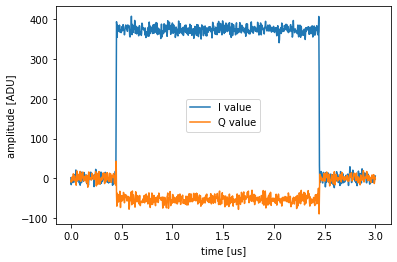

In [58]:
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3500,
          'freq': 4000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 2.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 5, 15)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

  0%|          | 0/1 [00:00<?, ?it/s]

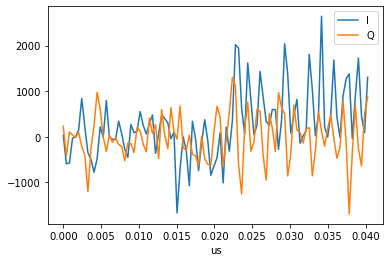

In [59]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[450:550]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

  0%|          | 0/100 [00:00<?, ?it/s]

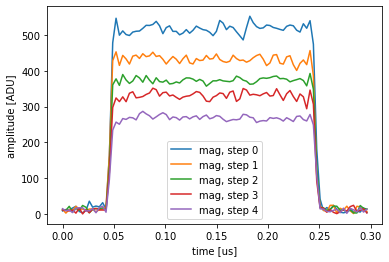

In [60]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", 3900, 4100),
          'mixer_freq': 4000,
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

#soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
#soc.rfb_set_ro_rf(config['ro_ch'], 30)
#freq = config['mixer_freq']
#soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
#soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)

# ^
freq = config['mixer_freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 5, 15)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)



prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
# for chain in soc.adc_chains:
#     chain.set_filter(fc=0, ftype='bypass')
# for chain in soc.dac_chains:
#     chain.set_filter(fc=0, ftype='bypass')

In [ ]:
# for i, chain in enumerate(soc.adc_chains):
#     print("ADC", i, chain.read_filter(reg='CHIPTYPE',debug=False))
# for i, chain in enumerate(soc.dac_chains):
#     print("DAC", i, chain.read_filter(reg='CHIPTYPE',debug=False))

## Transmission efficiency
The function below calculates the forward transmission coefficient ($S_{21}$) between the DAC and ADC channels in loopback.

In [61]:
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
    config = {'steps': steps,
              'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'nqz': nqz,
              'trig_time': 0.4,
              'pulse_len': 10.0,
              'ro_len': 10.1,
              'phase': 0,
              'gain': gain
             }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        config['freq'] = QickSweep1D("myloop", mixer_freq-dds_range*f_dds, mixer_freq+dds_range*f_dds)

        prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
        freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

        iq_complex = iq_list[0][0].dot([1,1j])
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers


## $S_{21}$ vs Frequency 

The following cell plots the $S_{21}$ as a function of the sweeping frequency. We can see that the RF board has a clear range at which the transmittance is optimized and generally that there is greater attenuation at higher frequencies as expected.

  0%|          | 0/7 [00:00<?, ?it/s]

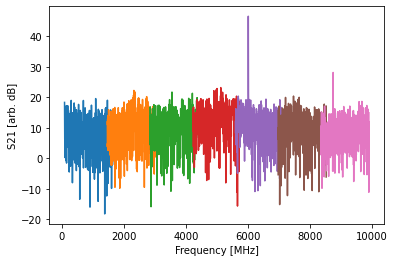

In [62]:
## need to figure out what's going on here ## - will go to QICK OH on Friday
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
measure_s21(15,0,2,1.0,steps=501,dds_range=0.45,overlap=0.1,plot=True);

## $S_{21}$ at different Nyquist zones

The RF board can be adjusted to have maximized transmittance in different Nyquist zones. As shown below, transmittance can be optimized at lower frequencies $\le f_s/2$ (e.g., the first Nyquist zone) by using nqz = 1 or at higher frequencies $\ge f_s/2$ (e.g., the second Nyquist zone) using nqz = 2 and so on.

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

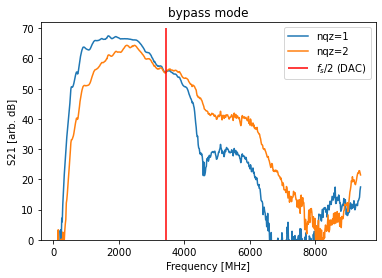

In [65]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

plt.plot(*measure_s21(GEN_CH,RO_CH,nqz = 1,gain = 1.0), label="nqz=1")
plt.plot(*measure_s21(GEN_CH,RO_CH,nqz = 2,gain = 1.0), label="nqz=2")
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("bypass mode")

# illustrating the nyquist zones
fs_adc = 2457.600
fs_dac = 6881.280
plt.vlines(fs_dac/2,0,70,color = 'red',label = r"$\f_s/2$ (DAC)")

plt.legend();

## Testing Low-pass and High-pass filtering

The RF board can be used to employ low- and high-pass filtering.

In [66]:
# just to be sure we're doing things right, set registers directly
def set_filter(gen_ch, ro_ch, lpf, hpf, filt=0):
    sw = 0xc0 + (hpf<<3) + lpf
    filt_bits = (filt<<4) + filt
    rfb_ch = soc.gens[gen_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

    rfb_ch = soc.avg_bufs[ro_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

## Low-pass filtering (LPF) example testing

### Low-pass filtering at differnt bands in state 0.

  0%|          | 0/5 [00:00<?, ?it/s]

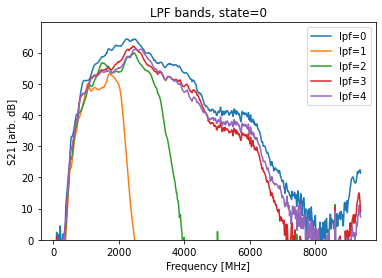

In [68]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for lpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, lpf, 0, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="lpf=%d"%(lpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF bands, state=0")
plt.legend();

### Low-pass filtering at differnt states in the second band.

  0%|          | 0/16 [00:00<?, ?it/s]

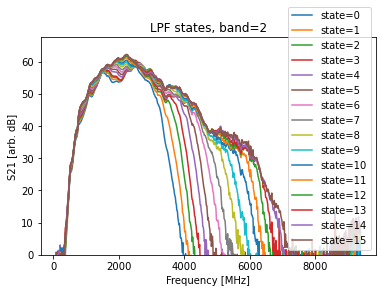

In [69]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 2, 0, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF states, band=2")
plt.legend();

## High-pass filtering (HPF) example testing

### High-pass filtering at differnt bands in state 0.

  0%|          | 0/5 [00:00<?, ?it/s]

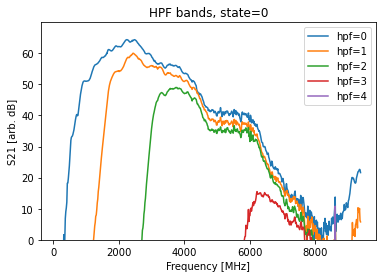

In [70]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for hpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, 0, hpf, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="hpf=%d"%(hpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF bands, state=0")
plt.legend();

### High-pass filtering at differnt states in the second band.

  0%|          | 0/16 [00:00<?, ?it/s]

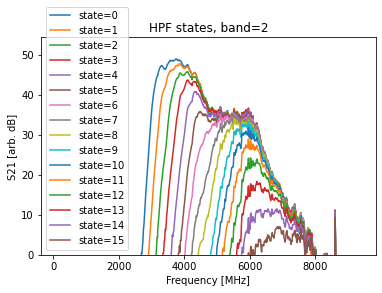

In [71]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 0, 2, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF states, band=2")
plt.legend();

## Bandpass filtering

Each DAC and ADC channels have programmable bandpass filters. We adjust the bandpass filtering by setting ```ftype = 'bandpass'``` in ```soc.rfb_set_ro_filter()```. The center frequency of the bandpass is set using ```f_c``` and the bandwidth is set with ```bw```.

For instance, ```soc.rfb_set_ro_filter(config['ro_ch'], fc=6, ftype='bandpass', bw=0.1)``` applies a bandpass filter on the ADC side with a frequency center at 6000 MHz and a width of 100 MHz (**???questions???**).

In [2]:
soc.rfb_set_gen_rf(config['gen_ch'], 5, 15)
soc.rfb_set_ro_rf(config['ro_ch'], 30)
freq = 6000
for bw in tqdm([1500, 1000, 500, 200, 100]):

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)
    soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)


    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="bw=%.2f"%(bw))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("filter center = %.2f MHz"%(freq));
plt.legend();


In [74]:
### MUX TEST
GEN_CH=5
MIXMUXGEN_CH = 4

RO_CH_MUX = [2,3,4,5,6,7]
RO_CH_MUX_RF = 5

freq = 6000 # 3000-5000 see nothing,6000 and 7000 see something, 8000+ see nothing 
soc.rfb_set_gen_filter(GEN_CH, fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(RO_CH_MUX_RF, fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(GEN_CH, 10, 0) # Verified 30->25 see increased gain in loopback
# Set attenuator on ADC.
soc.rfb_set_ro_rf(RO_CH_MUX_RF, 0) # Verified 30->25 see increased gain in loopback

In [ ]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': GEN_CH,
          'ro_chs': RO_CH_MUX,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
          'pulse_gains': [1.0]*6,
          'pulse_phases': [0.0]*6,
          'ro_phases': [0.0]*6,
          'trig_time': 0.0,
          'pulse_len': 0.5,
          'ro_len': 5.0,
         }
print(config)
prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=10)

In [ ]:
t = prog.get_time_axis(ro_index=0)
fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");
    ######## SET THIS VALUE AS YOUR config['trig_time'] #########
    plot.axvline(0.75, c='r') 



In [ ]:
### Scratchwork below: try to get a S21 sweep using the filters and a Python outer loop 

In [ ]:
### Testing MUX in loopback

### MUX TEST 2 
GEN_CH=5
MIXMUXGEN_CH = 4

RO_CH_MUX = [2,3,4,5,6,7]
RO_CH_MUX_RF = 5

freq = 6000
soc.rfb_set_gen_filter(MIXMUXGEN_CH, fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(RO_CH_MUX_RF, fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(MIXMUXGEN_CH, 20, 30)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(RO_CH_MUX_RF, 30)

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
  
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': RO_CH_MUX,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
          'pulse_gains': [1.0]*6,
          'pulse_phases': [0.0]*6,
          'ro_phases': [0.0]*6,
          'trig_time': 0.0,
          'pulse_len': 0.5,
          'ro_len': 5.0,
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
#     config = {'steps': steps,
#               'gen_ch': gen_ch,
#               'ro_ch': ro_ch,
#               'nqz': nqz,
#               'trig_time': 0.4,
#               'pulse_len': 10.0,
#               'ro_len': 10.1,
#               'phase': 0,
#               'gain': gain
#              }
    config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': RO_CH_MUX,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
          'pulse_gains': [1.0]*6,
          'pulse_phases': [0.0]*6,
          'ro_phases': [0.0]*6,
          'trig_time': 0.0,
          'pulse_len': 0.5,
          'ro_len': 5.0,
         }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
#         freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        freqs = mixer_freqs
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

        iq_complex = iq_list[0][0].dot([1,1j])
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers


In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
measure_s21(15,0,2,1.0,steps=501,dds_range=0.45,overlap=0.1,plot=True);

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

plt.plot(*measure_s21(GEN_CH,RO_CH,1,1.0), label="nqz=1")
plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0), label="nqz=2")
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("bypass mode")
plt.legend();

In [ ]:
# just to be sure we're doing things right, set registers directly
def set_filter(gen_ch, ro_ch, lpf, hpf, filt=0):
    sw = 0xc0 + (hpf<<3) + lpf
    filt_bits = (filt<<4) + filt
    rfb_ch = soc.gens[gen_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

    rfb_ch = soc.avg_bufs[ro_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()


In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for lpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, lpf, 0, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="lpf=%d"%(lpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF bands, state=0")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 2, 0, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF states, band=2")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for hpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, 0, hpf, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="hpf=%d"%(hpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF bands, state=0")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(GEN_CH, 30, 30)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 0, 2, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF states, band=2")
plt.legend();

In [ ]:
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 20)
freq = 6000
for bw in tqdm([1500, 1000, 500, 200, 100]):

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)
    soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)


    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="bw=%.2f"%(bw))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("filter center = %.2f MHz"%(freq));
plt.legend();


## scratchwork below, ignore

In [ ]:
### MUX TEST
GEN_CH=5
MIXMUXGEN_CH = 4

RO_CH_MUX = [2,3,4,5,6,7]
RO_CH=0

freq = 6000
soc.rfb_set_gen_filter(MIXMUXGEN_CH, fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(5, fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(MIXMUXGEN_CH, 20, 30)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(5, 30)

In [ ]:
class MuxProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_chs = cfg['ro_chs']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], ro_ch=ro_chs[0], 
                         mux_freqs=cfg['pulse_freqs'], 
                         mux_gains=cfg['pulse_gains'], 
                         mux_phases=cfg['pulse_phases'],
                         mixer_freq=cfg['mixer_freq'])
        for ch, f, ph in zip(cfg['ro_chs'], cfg['pulse_freqs'], cfg['ro_phases']):
            self.declare_readout(ch=ch, length=cfg['ro_len'], freq=f, phase=ph, gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mymux", 
                       style="const", 
                       length=cfg["pulse_len"],
                       mask=[0,1,2,3,4,5],
                      )
        
    def _body(self, cfg):
        self.trigger(ros=cfg['ro_chs'], pins=[0], t=cfg['trig_time'], ddr4=True)
        self.pulse(ch=cfg['gen_ch'], name="mymux", t=0)
        
config = {'gen_ch': MIXMUXGEN_CH,
          'ro_chs': RO_CH_MUX,
          'mixer_freq': 6000,
          'nqz': 2,
          'pulse_freqs': [6191.519, 6216, 6292.321, 6405.85, 6432.959, 6468.441],
          'pulse_gains': [1.0]*6,
          'pulse_phases': [0.0]*6,
          'ro_phases': [0.0]*6,
          'trig_time': 0.0,
          'pulse_len': 0.5,
          'ro_len': 5.0,
         }
print(config)
prog = MuxProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, soft_avgs=10)

In [ ]:
t = prog.get_time_axis(ro_index=0)
fig, axes = plt.subplots(len(config['ro_chs']), 1, figsize=(12,12))
for i, ch in enumerate(config['ro_chs']):
    plot = axes[i]
    plot.plot(t, iq_list[i][:,0], label="I value")
    plot.plot(t, iq_list[i][:,1], label="Q value")
    plot.plot(t, np.abs(iq_list[i].dot([1,1j])), label="magnitude")
    plot.legend()
    plot.set_ylabel("a.u.")
    plot.set_xlabel("us");
    ######## SET THIS VALUE AS YOUR config['trig_time'] #########
    plot.axvline(0.75, c='r') 



In [ ]:
from tqdm.auto import tqdm
config['ro_len'] += 10.0
config['pulse_len'] += 10.0
config['freq'] = QickSweep1D("myloop", 3800, 4200)
# config['freq'] = QickSweep1D("myloop", 3000, 7000)
config['steps']=1001

freq = 5000
soc.rfb_set_gen_filter(config['gen_ch'], fc=0, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=0, ftype='bypass')

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)

    prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
from tqdm.auto import tqdm
config['ro_len'] += 10.0
config['pulse_len'] += 10.0
config['freq'] = QickSweep1D("myloop", 3800, 4200)
# config['freq'] = QickSweep1D("myloop", 3000, 7000)
config['steps']=1001

freq = 5000
soc.rfb_set_gen_filter(config['gen_ch'], fc=0, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=0, ftype='bypass')

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)

    prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
print(prog.get_pulse_param('myro', 'freq', as_array=True))
print(prog.get_pulse_param('mypulse', 'freq', as_array=True))


In [ ]:
class SimpleSweepProgram2(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel='input')

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
#                        mode='periodic'
                      )

        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

In [ ]:
# do a sweep with 5 points and plot decimated
config = {'gen_ch': 2,
          'ro_ch': 1,
          'freq': 5000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 0.5,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)



freq = config['freq']

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)

#######
# ADC #
#######
# Set Filter.
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)


iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()[800:900]
t = prog.get_time_axis_mr(config['ro_ch'], iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [ ]:
from scipy.signal import welch
from numpy.fft import fftshift

soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

soc.arm_mr(ch=config['ro_ch'])
iq_list = prog.acquire_decimated(soc, soft_avgs=1)

iq_mr = soc.get_mr()[:,0]
fs_mr = soccfg['readouts'][config['ro_ch']]['fs']
# fft_freqs, psd = fftshift(welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False), axes=1)
fft_freqs, psd = welch(iq_mr, fs_mr, return_onesided=True, nperseg=128, detrend=False)
plt.semilogy(fft_freqs, psd)
plt.xlabel("MHz")

In [ ]:
for chain in soc.dac_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_rf(5,5)

In [ ]:
for chain in soc.adc_chains:
    chain.set_filter(fc=1.5, bw=1, ftype='bypass')
    chain.set_attn_db(5)

In [ ]:
rfb_cfg = {'gen_ch': 2,
        'ro_ch': 1,
        'gen_att': (10,30),
        'ro_att': 30,
        }
soc.rfb_set_gen_rf(rfb_cfg['gen_ch'], *rfb_cfg['gen_att'])
soc.rfb_set_ro_rf(rfb_cfg['ro_ch'], rfb_cfg['ro_att'])

soc.rfb_set_ro_filter(rfb_cfg['ro_ch'], fc=1.0, ftype='bypass')
soc.rfb_set_gen_filter(rfb_cfg['gen_ch'], fc=1.0, ftype='bypass')


In [ ]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 2,
          'ro_ch': 1,
          'freq': QickSweep1D("myloop", 4000, 7000),
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

soc.rfb_set_gen_rf(config['gen_ch'], 10, 30)
soc.rfb_set_ro_rf(config['ro_ch'], 30)

prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
from tqdm.auto import tqdm
config['freq'] = QickSweep1D("myloop", 3000, 6000)
config['steps']=5001

freq = 5000

for ro_bw in tqdm([1.5, 1.0, 0.5, 0.2, 0.1]):
#     soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     for chain in soc.adc_chains:
# #         chain.set_filter(fc=5.0, ftype='bandpass', bw=ro_bw)
#         chain.set_filter(fc=9.0, ftype='lowpass', bw=ro_bw)

#     soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=ro_bw)
#     soc.rfb_set_gen_filter(config['gen_ch'], fc=3.0, ftype='bandpass', bw=0.5)

    prog = FreqSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
    freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
    # plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
    # plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
    # plt.ylabel("Q [ADU]")
    # plt.xlabel("I [ADU]");

    iq_complex = iq_list[0][0].dot([1,1j])
    mags = np.abs(iq_complex)

    plt.semilogy(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
    # plt.ylabel("Phase [cycles]")
    # plt.xlabel("Frequency [MHz]")

    # print("phase step (cycles):", phases[1]-phases[0])

plt.title("filter center = %f MHz"%(freq))
plt.legend();

In [ ]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", 
                               freq=cfg['freq'], 
                               gen_ch=gen_ch, 
                               outsel=cfg['ro_outsel'])

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        ramp_len = 2.0
#         self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        self.add_triangle(ch=gen_ch, name="triangle", length=ramp_len, even_length=True)
        
#         self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
#                        style="arb", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        phase=0,
#                        gain=1.0, 
#                       )
        self.add_pulse(ch=gen_ch, name="mytri", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="triangle", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )
        
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mytri", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)
        
        
        
config = {'gen_ch': 2,
          'ro_ch': 1,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'ro_outsel': 'product',
          'pulse_len': 0.5,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

freq = config['freq']

# soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bypass')
# soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bypass')



# # Set Filter.
# # soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass')
# # soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# # Set attenuator on DAC.
# # soc.rfb_set_gen_rf(config['gen_ch'], 5, 5)
# soc.rfb_set_gen_rf(config['gen_ch'], 5, 20)

# #######
# # ADC #
# #######
# # Set Filter.
# # soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass')

# # Set attenuator on ADC.
# soc.rfb_set_ro_rf(config['ro_ch'], 20)

rfb_cfg = {'gen_ch': 2,
        'ro_ch': 1,
        'gen_att': (10,30),
        'ro_att': 30,
        }
soc.rfb_set_gen_rf(rfb_cfg['gen_ch'], *rfb_cfg['gen_att'])
soc.rfb_set_ro_rf(rfb_cfg['ro_ch'], rfb_cfg['ro_att'])

soc.rfb_set_ro_filter(rfb_cfg['ro_ch'], fc=1.0, ftype='bypass')
soc.rfb_set_gen_filter(rfb_cfg['gen_ch'], fc=1.0, ftype='bypass')

iq_list = prog.acquire_decimated(soc, soft_avgs=10)
t = prog.get_time_axis(ro_index=0)

iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
# plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [ ]:
##########################################
### One generator/readout and raw-data ###
##########################################
class ReadoutTest(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone for the DACs.
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=self.cfg['gen_nqz'])
        
        # DAC channel.
        freq = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'][0])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'], 
                                 style  = 'const', 
                                 freq   = freq,
                                 phase  = 0, 
                                 gain   = self.cfg['pulse_gain'], 
                                 length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch']))
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'][0], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch'][0]),
                             freq    = self.cfg['ro_freq'],
                             gen_ch  = self.cfg['gen_ch'])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):       
        self.measure(pulse_ch        = self.cfg['gen_ch'], 
                     adcs            = self.cfg['ro_ch'],
                     pins            = [0],
                     t               = self.us2cycles(self.cfg['pulse_start']),
                     adc_trig_offset = self.us2cycles(self.cfg['ro_offset'], ro_ch = self.cfg['ro_ch'][0]),
                     )        

config={"ro_ch"       : [5],
        "ro_length"   : 40,
        "ro_freq"     : 4000,
        "ro_offset"   : 0,
        
        "gen_ch"      : 12,        
        "gen_nqz"     : 2,
        "pulse_length": 20,
        "pulse_start" : 10,
        "pulse_gain"  : 30000,
        "pulse_freq"  : 4000,
        
        "reps"        : 1,
        "period"      : 20
       }

########################
### RF Board Setting ###
########################

#######
# DAC #
#######
freq = config['pulse_freq']

# Set Filter.
# soc.rfb_set_gen_filter(config['gen_ch'], fc=fc, ftype='bandpass')
soc.rfb_set_gen_filter(config['gen_ch'], fc=2.5, ftype='lowpass')

# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 15, 20)

#######
# ADC #
#######
# Set Filter.
soc.rfb_set_ro_filter(config['ro_ch'][0], fc=freq/1000, ftype='bandpass')

# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'][0], 20)

prog = ReadoutTest(soccfg, config)
iq_list = prog.acquire_decimated(soc)

# Plot Captured Data.
plt.figure(dpi=200)

yi = iq_list[0][0]
yq = iq_list[0][1]
t = soccfg.cycles2us(ro_ch=config['ro_ch'][0], cycles=np.arange(len(iq_list[0][0])))

plt.plot(t,yi)
plt.plot(t,yq)
    
plt.xlabel('t [us]');
plt.legend(['I','Q']);


In [ ]:
from tqdm.auto import tqdm
for i in tqdm(range(1000)):
    soc.rfb_set_gen_rf(gen_ch=0, att1=15, att2=20)


### little note on the generator outputs
This firmware uses the "tmux" which multiplexes multiple generators onto each tProc output. Generally this works transparently, but be aware that if you try to play simultaneous pulses on generators that share a tmux channel, the pulses will get offset by a tProc clock cycle (or something like that).

In [ ]:
soccfg['gens']

In [ ]:
[(i,gen['tproc_ch']) for i,gen in enumerate(soccfg['gens'])]

In [ ]:
soc.ip_dict.keys()

### playing with LEDs (and ribbon I/O connector)
The LEDs are wired to the PMOD0 connector on the ZCU216, the ribbon is wired to PMOD1. In this firmware these are connected to an AxiGPIO which is controlled by software (vs. in most QICK firmware, where the PMODs are connected to the tProc). So these are for slow control.

The LEDs are very dim (trying to drive the LEDs directly with PMOD outputs?).

There is also some weirdness with the AxiGPIO we're using for this.

The ribbon connector works identically (`soc.pmod_bits_gpio` instead of `soc.pmod_led_gpio`), except that the pin mapping seems to be screwed up somewhere, such that even and odd pins are swapped: PMOD1_0=ribbon signal 1, PMOD 1_1=ribbon signal 0, etc. The ribbon pins should be input-capable, but I haven't checked.

In [ ]:
help(soc.pmod_led_gpio)

In [ ]:
# this works
while True:
    for ch in soc.pmod_led_gpio:
        ch.on()
    time.sleep(1)
    for ch in soc.pmod_led_gpio:
        ch.off()
    time.sleep(1)
    

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].on()
            else:
                soc.pmod_led_gpio[j].off()
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        for j in range(8):
            if i==j:
                soc.pmod_led_gpio[j].write(1)
            else:
                soc.pmod_led_gpio[j].write(0)
        time.sleep(0.2)

In [ ]:
# this works
while True:
    for i in range(8):
        soc.pmod_led_gpio.channel1.write(val=1<<i, mask=0xFF)
        time.sleep(0.2)


In [ ]:
# this doesn't work, not sure why
while True:
    soc.pmod_led_gpio.channel1.write(0x0,0xFF)
    time.sleep(1)
    soc.pmod_led_gpio.channel1.write(0xFF,0xFF)
    time.sleep(1)
    

In [ ]:
help(soc.pmod_led_gpio.channel1.write)